In [9]:
import sys
sys.path.append('..')

In [15]:
import os
import numpy as np
import torch
from model import Tacotron
from utils.text import phoneme_to_sequence
from utils.text.symbols import phonemes
from utils.audio import AudioProcessor

In [18]:
gpu_id = 3
device = torch.device('cuda:{}'.format(gpu_id)
                      if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=3)

In [12]:
ap = AudioProcessor()

AudioProcessor
  sample_rate:22050
  num_mels:80
  num_freq:1025
  frame_length_ms:50
  frame_shift_ms:12.5
  preemphasis:0.98
  min_level_db:-100
  ref_level_db:20
  power:1.5
  mel_fmin:0.0
  mel_fmax:8000.0
  griffin_lim_iters:60
  n_fft:2048
  hop_length:275
  win_length:1100


In [13]:
num_chars = len(phonemes)

In [19]:
model = Tacotron(num_chars).to(device)

In [34]:
model_path = '../runs/finished/Oct04_17-14-49_K-00030-LIN/checkpoint_370000.pth'
cp = torch.load(model_path)
cp.keys()

dict_keys(['model', 'optimizer', 'optimizer_st', 'step', 'epoch', 'linear_loss'])

- このlinear_lossはstepの値なのでTensorBoardに記録されている平均lossよりも低めにでることがある

In [37]:
cp['epoch'], cp['step'], cp['linear_loss']

(986, 370000, 0.4926067888736725)

In [64]:
model.load_state_dict(cp['model'])

<All keys matched successfully>

In [79]:
text = 'Be a voice, not an echo.'

In [80]:
inputs = phoneme_to_sequence(text, ['phoneme_cleaners'], language='en-us', enable_eos_bos=False)

In [81]:
print(inputs)  # 音素ID系列

[4, 10, 110, 128, 39, 128, 23, 43, 63, 20, 122, 128, 15, 40, 110, 21, 128, 39, 15, 128, 50, 12, 16, 89, 124]


In [82]:
inputs = np.asarray(inputs, dtype=np.int32)
inputs = torch.from_numpy(inputs).unsqueeze(0).long().to(device)

In [83]:
inputs

tensor([[  4,  10, 110, 128,  39, 128,  23,  43,  63,  20, 122, 128,  15,  40,
         110,  21, 128,  39,  15, 128,  50,  12,  16,  89, 124]],
       device='cuda:3')

In [84]:
print(inputs.shape)

torch.Size([1, 25])


In [85]:
decoder_output, postnet_output, alignments, stop_tokens = model.inference(inputs)

- alignmentsとstop_tokensはrフレームまとめたセグメントが単位
- 実際のフレーム数は 24 * 7 = 168

In [86]:
print(decoder_output.shape)  # mel spectrogram
print(postnet_output.shape)  # linear spectrogram
print(alignments.shape)
print(stop_tokens.shape)

torch.Size([1, 161, 80])
torch.Size([1, 161, 1025])
torch.Size([1, 23, 25])
torch.Size([1, 23])


## アラインメントの可視化

In [87]:
alignment = alignments[0]

In [88]:
alignment.shape

torch.Size([23, 25])

In [90]:
alignment = alignment.data.cpu().numpy()

Text(0, 0.5, 'Encoder timestep (phonemes)')

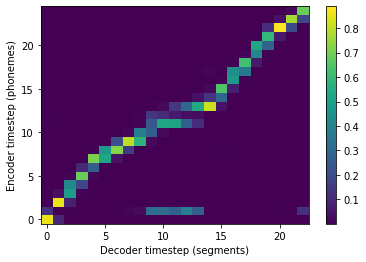

In [95]:
plt.imshow(alignment.T, aspect='auto', origin='lower', interpolation='none');
plt.colorbar()
plt.xlabel('Decoder timestep (segments)')
plt.ylabel('Encoder timestep (phonemes)')